# Mean-variance optimization

In [ ]:
from typing import List
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

def calc_corv(deviations: np.ndarray, corr: np.ndarray) -> np.ndarray:
    """
    This function calculates the covariance matrix based on a given correlation matrix and array of standard deviations.

    Args:
    - deviations (np.ndarray): 1D array of standard deviations for each variable.
    - corr (np.ndarray): 2D correlation matrix.

    Returns:
    - 2D covariance matrix calculated from the input arrays.
    """
    # Calculate the outer product of the standard deviations to get a matrix of variances
    variances = np.outer(deviations, deviations)
    
    # Calculate the covariance matrix by element-wise multiplication of the correlation matrix with the variance matrix
    return corr * variances

def portolio_return(weights, returns):
    return np.dot(weights, returns)

def portfolio_variance(weights, cov_matrix):
    port_variance = np.dot(np.dot(weights, cov_matrix), weights.T)
    return port_variance

def sharpe_ratio(weights, returns, cov_matrix, rf_return):
    return (portolio_return(weights, returns) - rf_return) / \
        (portfolio_variance(weights, cov_matrix)**0.5)

def find_mve(returns, cov_matrix, rf_return):
    # Constraints: weights must sum up to 1
    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

    # Bounds on weights: each weight must be between 0 and 1
    bnds = [(0, 1) for i in range(0, len(cov_matrix))]

    # Initial guess of equal weights for each asset
    init_guess = [1/len(cov_matrix) for i in range(0, len(cov_matrix))]

    # Solve the optimization problem
    opt_results = minimize(
        lambda w: -sharpe_ratio(w, returns, cov_matrix, rf_return), 
        init_guess, 
        constraints=cons, 
        bounds=bnds)
    weights = np.round(opt_results.x, decimals=3)
    p_return = portolio_return(weights, returns)
    p_deviation = portfolio_variance(weights, cov_matrix)**0.5
    sr = sharpe_ratio(weights, returns, cov_matrix, rf_return)
    labels = np.append(['w' + str(i) for i in range(1, len(weights)+1)], 
        ['Return', 'Deviation', 'Sharpe Ratio'])
    return pd.Series(np.append(weights, [p_return, p_deviation, sr]), index=labels)

## Mean-variance efficient portfolio (two assets)

Define two risky assets and return of risk-free asset:

In [ ]:
assets_df = pd.DataFrame({
  'Return': [0.1355, 0.1497],
  'Deviation': [0.1535, 0.2298]
}, index=['US', 'Japan'])
asset_corr = pd.DataFrame({
  'US': [1, 0.2663],
  'Japan': [0.2663, 1],
}, index=['US',  'Japan'])
rf_return = 0.05
asset_cov = calc_corv(assets_df['Deviation'], asset_corr.to_numpy())
asset_cov

Find the mean-variance efficient portfolio

In [ ]:
mve = find_mve(assets_df['Return'], asset_cov, rf_return)
mve

Construct capital allocation line

In [48]:
cal_df = pd.DataFrame({ 'w_mve': np.arange(0, 1.8, step=0.1) })
cal_df['w_rf'] = 1 - cal_df['w_mve']
cal_df['Return'] = np.dot(cal_df[['w_mve', 'w_rf']], [mve['Return'], rf_return])
cal_df['Deviation'] = cal_df['w_mve'] * mve['Deviation']
cal_df['Sharpe ratio'] = (cal_df['Return'] - rf_return)/cal_df['Deviation']
cal_df.head()

,w_mve,w_rf,Return,Deviation,Sharpe ratio
0,0.0,1.0,0.050000,0.000000,NaN
1,0.1,0.9,0.058979,0.014232,0.630872
2,0.2,0.8,0.067958,0.028465,0.630872
3,0.3,0.7,0.076937,0.042697,0.630872
4,0.4,0.6,0.085915,0.056930,0.630872


Construct mean variance frontier

In [51]:
ef_df = pd.DataFrame({ 'w_us': np.arange(0, 1.1, step=0.01) })
ef_df['w_jp'] = 1 - ef_df['w_us']
ef_df['Return'] = np.dot(ef_df[['w_us', 'w_jp']], assets_df['Return'])
ef_df['Deviation'] = np.sqrt(np.apply_along_axis(
  lambda x: np.dot(np.dot(x.T, asset_cov), x), 
  axis=1, arr=ef_df[['w_us', 'w_jp']].values
))

ef_df.head()

,w_us,w_jp,Return,Deviation
0,0.00,1.00,0.149700,0.229800
1,0.01,0.99,0.149558,0.227916
2,0.02,0.98,0.149416,0.226041
3,0.03,0.97,0.149274,0.224176
4,0.04,0.96,0.149132,0.222322


Plot the data

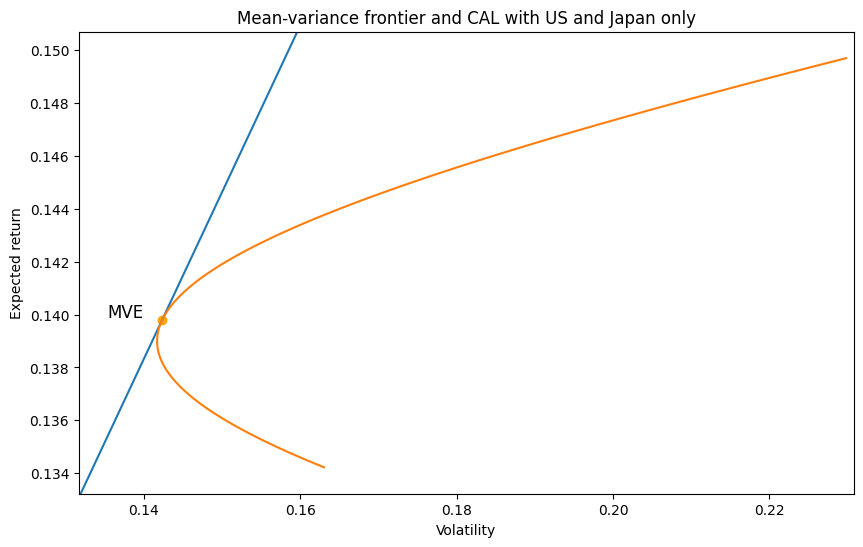

In [52]:
# Create the plot
fig, ax = plt.subplots(figsize=(10,6))

# plot capital allocation line
ax.plot(cal_df['Deviation'], cal_df['Return'])

# plot efficient frontier
ax.plot(ef_df['Deviation'], ef_df['Return'])

# plot mearn-variance efficient portfolio
ax.scatter(mve['Deviation'], mve['Return'], color='orange')
ax.text(mve['Deviation']-0.007, mve['Return']+0.0001, 'MVE', fontsize=12)

# add title and x/y-axis labels
plt.title('Mean-variance frontier and CAL with US and Japan only')
plt.xlabel('Volatility')
plt.ylabel('Expected return')

# Set the limits of axes
plt.ylim(ef_df['Return'].min() - 0.001, ef_df['Return'].max()+0.001)
plt.xlim(ef_df['Deviation'].min() - 0.01, ef_df['Deviation'].max()+0.001)

# Show the graph
plt.show()

## Mean variance frontier of multiple assets

In [ ]:
assets_df = pd.DataFrame({
  'return': [0.1355, 0.1589, 0.1519, 0.1435, 0.1497],
  'deviation': [0.1535, 0.2430, 0.2324, 0.2038, 0.2298]
}, index=['US', 'UK', 'France', 'Germany', 'Japan'])
r_rf = 0.05
corr_df = pd.DataFrame({
  'US': [1.0000, 0.5003, 0.4398, 0.3681, 0.2663],
  'UK': [0.5003, 1.0000, 0.5420, 0.4265, 0.3581],
  'France': [0.4398, 0.5420, 1.0000, 0.6032, 0.3923],
  'Germany': [0.3681, 0.4265, 0.6032, 1.0000, 0.3663],
  'Japan': [0.2663, 0.3581, 0.3923, 0.3663, 1.0000],
}, index=['US', 'UK', 'France', 'Germany', 'Japan'])

# create corvariance matrix from deviations and correlation matrix
diag_matrix = np.diag(assets_df['deviation'])
cov_matrix_1 = np.dot(diag_matrix, corr_df.to_numpy())
cov_matrix = np.dot(cov_matrix_1, diag_matrix.T)
cov_matrix

Find the minimum variance portfolio (GMV)

In [ ]:
def portfolio_variance(weights, cov_matrix):
    port_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    return port_variance

def find_gmv_weights(cov_matrix):
    # Constraints: weights must sum up to 1
    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

    # Bounds on weights: each weight must be between 0 and 1
    bnds = [(0, 1) for i in range(0, len(cov_matrix))]

    # Initial guess of equal weights for each asset
    init_guess = [1/len(cov_matrix) for i in range(0, len(cov_matrix))]

    # Solve the optimization problem
    opt_results = minimize(portfolio_variance, 
        init_guess, 
        args=(cov_matrix),
        constraints=cons, 
        bounds=bnds)
    return opt_results.x

gmv_weights = find_gmv_weights(cov_matrix)

Find the mean variance efficient portfolio (MVE)

In [ ]:
def portolio_return(weights, returns):
    return np.dot(weights, returns)

def portfolio_variance(weights, cov_matrix):
    port_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    return port_variance

def sharpe_ratio(weights, returns, cov_matrix, rf_return):
    return (portolio_return(weights, returns) - rf_return) / \
        (portfolio_variance(weights, cov_matrix)**0.5)

def find_mve_weights(returns, cov_matrix, rf_return):
    # Constraints: weights must sum up to 1
    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

    # Bounds on weights: each weight must be between 0 and 1
    bnds = [(0, 1) for i in range(0, len(cov_matrix))]

    # Initial guess of equal weights for each asset
    init_guess = [1/len(cov_matrix) for i in range(0, len(cov_matrix))]

    # Solve the optimization problem
    opt_results = minimize(
        lambda w: -sharpe_ratio(w, returns, cov_matrix, rf_return), 
        init_guess, 
        # args=(),
        constraints=cons, 
        bounds=bnds)
    return opt_results.x

mve_weights = find_mve_weights(assets_df['return'].values, cov_matrix, r_rf)
mve_weights

In [ ]:
corr = np.dot(gmv_weights, np.dot(mve_weights, cov_matrix))
portfolio_cov_df = pd.DataFrame({
  'GMV': [portfolio_variance(gmv_weights, cov_matrix), corr],
  'MVE': [corr, portfolio_variance(mve_weights, cov_matrix)]
}, index=['GMV', 'MVE'])
portfolio_rd = pd.DataFrame({
  'return': [portolio_return(gmv_weights, assets_df['return']), portolio_return(mve_weights, assets_df['return'])],
  'deviation': [portfolio_variance(gmv_weights, cov_matrix)**0.5, portfolio_variance(mve_weights, cov_matrix)**0.5]
}, index=['GMV', 'MVE'])
portfolio_rd

Plot the mean variance frontier by varying the weights of the two porfolio

In [ ]:
mvf = pd.DataFrame({ 'gmv_w': np.arange(-1.1, 2.1, step=0.1) })
mvf['mve_w'] = 1 - mvf['gmv_w']
mvf['return'] = np.dot(mvf[['gmv_w', 'mve_w']], portfolio_rd['return'])
# mvf['deviation'] = 
# mvf['D'] = portfolio_volatility(mvf['w_us'], mvf['w_jp'], s_us, s_jp, corr)
mvf